In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import json
from PIL import Image
from glob import glob
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from skimage import transform
from torchvision import transforms
import random
from torch.utils.data import DataLoader

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value
    https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """

        Args:
            val: mini-batch loss or accuracy value
            n: mini-batch size
        """
        self.val = val
        self.sum += val 
        self.count += n
        self.avg = self.sum / self.count

In [20]:
data_dir = './xBD_all/' 

all_disaster_splits_json_filename = './all_disaster_splits.json'
label_map_json_file = './nlrc.building-damage-assessment/constants/class_lists/xBD_label_map.json'

def load_json_files(json_filename):
    with open(json_filename) as f:
        file_content = json.load(f)
    return file_content

splits = load_json_files(all_disaster_splits_json_filename)
label_map = load_json_files(label_map_json_file)

In [21]:
# get list of train, val, test images
splits.keys()
all_images_ls = [] 
for item, val in splits.items():
    all_images_ls += val['train'] 
    all_images_ls += val['test'] 
    all_images_ls += val['val'] 


len(all_images_ls)
all_images_ls[1:20]

dict_keys(['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey', 'mexico-earthquake', 'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire', 'socal-fire', 'lower-puna-volcano', 'nepal-flooding', 'pinery-bushfire', 'portugal-wildfire', 'sunda-tsunami', 'woolsey-fire', 'hurricane-matthew', 'hurricane-michael', 'joplin-tornado', 'moore-tornado', 'tuscaloosa-tornado'])

11034

['raw/hold/labels/guatemala-volcano_00000012',
 'raw/hold/labels/guatemala-volcano_00000014',
 'raw/hold/labels/guatemala-volcano_00000020',
 'raw/hold/labels/guatemala-volcano_00000022',
 'raw/test/labels/guatemala-volcano_00000003',
 'raw/test/labels/guatemala-volcano_00000005',
 'raw/test/labels/guatemala-volcano_00000009',
 'raw/test/labels/guatemala-volcano_00000011',
 'raw/test/labels/guatemala-volcano_00000021',
 'raw/train/labels/guatemala-volcano_00000000',
 'raw/train/labels/guatemala-volcano_00000001',
 'raw/train/labels/guatemala-volcano_00000006',
 'raw/train/labels/guatemala-volcano_00000008',
 'raw/train/labels/guatemala-volcano_00000010',
 'raw/train/labels/guatemala-volcano_00000013',
 'raw/train/labels/guatemala-volcano_00000015',
 'raw/train/labels/guatemala-volcano_00000018',
 'raw/train/labels/guatemala-volcano_00000023',
 'raw/train/labels/guatemala-volcano_00000024']

In [22]:
class DisasterDataset_img(Dataset):
    def __init__(self, data_dir, data_dir_ls, transform:bool, scale=1, mask_suffix=''):
        
        self.data_dir = data_dir
        self.dataset_sub_dir = data_dir_ls
        self.scale = scale
        self.transform = transform
        
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

    def __len__(self):
        return len(self.dataset_sub_dir)
        
        return img_trans
    
    
    def __getitem__(self, i):
        
        imgs_dir = self.data_dir + self.dataset_sub_dir[i].replace('labels', 'images')

        idx = imgs_dir
        
        pre_img_file_name = imgs_dir + '_pre_disaster'
        pre_img_file = glob(pre_img_file_name + '.*')

        post_img_file_name = pre_img_file_name.replace('pre', 'post')
        post_img_file = glob(post_img_file_name + '.*')

        assert len(pre_img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {pre_img_file}'
        assert len(post_img_file) == 1, \
            f'Either no post disaster image or multiple images found for the ID {idx}: {post_img_file}'

        pre_img = np.array(Image.open(pre_img_file[0]))
        post_img = np.array(Image.open(post_img_file[0]))

        assert pre_img.size == post_img.size, \
            f'Pre_ & _post disaster Images {idx} should be the same size, but are {pre_img.size} and {post_img.size}'

        return {'pre_image': pre_img, 'post_image': post_img}, {'pre_img_file_name': pre_img_file_name, 'post_img_file_name':post_img_file_name}

In [31]:
# compute mean

mean_c1 = AverageMeter()
mean_c2 = AverageMeter()
mean_c3 = AverageMeter()

xBD_all = DisasterDataset_img(data_dir, all_images_ls, transform=True)
print('xBD_disaster_dataset length: {}'.format(len(xBD_all)))

for batch_idx, data in enumerate(xBD_all):

    data = data[0]
    x_pre = data['pre_image']
    x_post = data['post_image']
    
    mean_c1.update(x_pre[:,:,0].sum(), x_pre[:,:,0].size)
    mean_c1.update(x_post[:,:,0].sum(), x_post[:,:,0].size)

    mean_c2.update(x_pre[:,:,1].sum(), x_pre[:,:,1].size)
    mean_c2.update(x_post[:,:,1].sum(), x_post[:,:,1].size)

    mean_c3.update(x_pre[:,:,2].sum(), x_pre[:,:,2].size)
    mean_c3.update(x_post[:,:,2].sum(), x_post[:,:,2].size)


mean_c1.avg
mean_c2.avg
mean_c3.avg

xBD_disaster_dataset length: 11034


0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

124

125

126

127

128

129

130

131

132

133

134

135

136

137

138

139

140

141

142

143

144

145

146

147

148

149

150

151

152

153

154

155

156

157

158

159

160

161

162

163

164

165

166

167

168

169

170

171

172

173

174

175

176

177

178

179

180

181

182

183

184

185

186

187

188

189

190

191

192

193

194

195

196

197

198

199

200

201

202

203

204

205

206

207

208

209

210

211

212

213

214

215

216

217

218

219

220

221

222

223

224

225

226

227

228

229

230

231

232

233

234

235

236

237

238

239

240

241

242

243

244

245

246

247

248

249

250

251

252

253

254

255

256

257

258

259

260

261

262

263

264

265

266

267

268

269

270

271

272

273

274

275

276

277

278

279

280

281

282

283

284

285

286

287

288

289

290

291

292

293

294

295

296

297

298

299

300

301

302

303

304

305

306

307

308

309

310

311

312

313

314

315

316

317

318

319

320

321

322

323

324

325

326

327

328

329

330

331

332

333

334

335

336

337

338

339

340

341

342

343

344

345

346

347

348

349

350

351

352

353

354

355

356

357

358

359

360

361

362

363

364

365

366

367

368

369

370

371

372

373

374

375

376

377

378

379

380

381

382

383

385

386

387

388

389

390

391

392

393

394

395

396

397

398

399

400

401

402

403

404

405

406

407

408

409

410

411

412

413

414

415

416

417

418

419

420

421

422

423

424

425

426

427

428

429

430

431

432

433

434

435

436

437

438

439

440

441

442

443

444

445

446

447

448

449

450

451

452

453

454

455

456

457

458

459

460

461

462

463

464

465

466

467

468

469

470

471

472

473

474

475

476

477

478

479

480

481

482

483

484

485

486

487

488

489

490

491

492

493

494

495

496

497

498

499

500

501

502

503

504

505

506

507

508

509

510

511

512

513

514

515

516

517

518

519

520

521

522

523

524

525

526

527

528

529

530

531

532

533

534

535

536

537

538

539

540

541

542

543

544

545

546

547

548

549

550

551

552

553

554

555

556

557

558

559

560

561

562

563

564

565

566

567

568

569

570

571

572

573

574

575

576

577

578

579

580

581

582

583

584

585

586

587

588

589

590

591

592

593

594

595

596

597

598

599

600

601

602

603

604

605

606

607

608

609

610

611

612

613

614

615

616

617

618

619

620

621

622

623

624

625

626

627

628

629

630

631

632

633

634

635

636

637

638

639

640

641

642

643

644

645

646

647

648

649

650

651

652

653

654

655

656

657

658

659

660

661

662

663

664

665

666

667

668

669

670

671

672

673

674

675

676

677

678

679

680

681

682

683

684

685

686

687

688

689

690

691

692

693

694

695

696

697

698

699

700

701

702

703

704

705

706

707

708

709

710

711

712

713

714

715

716

717

718

719

720

721

722

723

724

725

726

727

728

729

730

731

732

733

734

735

736

737

738

739

740

741

742

743

744

745

746

747

748

749

750

751

752

753

754

755

756

757

758

759

760

761

762

763

764

765

766

767

768

769

770

771

772

773

774

775

776

777

778

779

780

781

782

783

784

785

786

787

788

789

790

791

792

793

794

795

796

797

798

799

800

801

802

803

804

805

806

807

808

809

810

811

812

813

814

815

816

817

818

819

820

821

822

823

824

825

826

827

828

829

830

831

832

833

834

835

836

837

838

839

840

841

842

843

844

845

846

847

848

849

850

851

852

853

854

855

856

857

858

859

860

861

862

863

864

865

866

867

868

869

870

871

872

873

874

875

876

877

878

879

880

881

882

883

884

885

886

887

888

889

890

891

892

893

894

895

896

897

898

899

900

901

902

903

904

905

906

907

908

909

910

911

912

913

914

915

916

917

918

919

920

921

922

923

924

925

926

927

928

929

930

931

932

933

934

935

936

937

938

939

940

941

942

943

944

945

946

947

948

949

950

951

952

953

954

955

956

957

958

959

960

961

962

963

964

965

966

967

968

969

970

971

972

973

974

975

976

977

978

979

980

981

982

983

984

985

986

987

988

989

990

991

992

993

994

995

996

997

998

999

1000

1001

1002

1003

1004

1005

1006

1007

1008

1009

1010

1011

1012

1013

1014

1015

1016

1017

1018

1019

1020

1021

1022

1023

1024

1025

1026

1027

1028

1029

1030

1031

1032

1033

1034

1035

1036

1037

1038

1039

1040

1041

1042

1043

1044

1045

1046

1047

1048

1049

1050

1051

1052

1053

1054

1055

1056

1057

1058

1059

1060

1061

1062

1063

1064

1065

1066

1067

1068

1069

1070

1071

1072

1073

1074

1075

1076

1077

1078

1079

1080

1081

1082

1083

1084

1085

1086

1087

1088

1089

1090

1091

1092

1093

1094

1095

1096

1097

1098

1099

1100

1101

1102

1103

1104

1105

1106

1107

1108

1109

1110

1111

1112

1113

1114

1115

1116

1117

1118

1119

1120

1121

1122

1123

1124

1125

1126

1127

1128

1129

1130

1131

1132

1133

1134

1135

1136

1137

1138

1139

1140

1141

1142

1143

1144

1145

1146

1147

1148

1149

1150

1151

1152

1153

1154

1155

1156

1157

1158

1159

1160

1161

1162

1163

1164

1165

1166

1167

1168

1169

1170

1171

1172

1173

1174

1175

1176

1177

1178

1179

1180

1181

1182

1183

1184

1185

1186

1187

1188

1189

1190

1191

1192

1193

1194

1195

1196

1197

1198

1199

1200

1201

1202

1203

1204

1205

1206

1207

1208

1209

1210

1211

1212

1213

1214

1215

1216

1217

1218

1219

1220

1221

1222

1223

1224

1225

1226

1227

1228

1229

1230

1231

1232

1233

1234

1235

1236

1237

1238

1239

1240

1241

1242

1243

1244

1245

1246

1247

1248

1249

1250

1251

1252

1253

1254

1255

1256

1257

1258

1259

1260

1261

1262

1263

1264

1265

1266

1267

1268

1269

1270

1271

1272

1273

1274

1275

1276

1277

1278

1279

1280

1281

1282

1283

1284

1285

1286

1287

1288

1289

1290

1291

1292

1293

1294

1295

1296

1297

1298

1299

1300

1301

1302

1303

1304

1305

1306

1307

1308

1309

1310

1311

1312

1313

1314

1315

1316

1317

1318

1319

1320

1321

1322

1323

1324

1325

1326

1327

1328

1329

1330

1331

1332

1333

1334

1335

1336

1337

1338

1339

1340

1341

1342

1343

1344

1345

1346

1347

1348

1349

1350

1351

1352

1353

1354

1355

1356

1357

1358

1359

1360

1361

1362

1363

1364

1365

1366

1367

1368

1369

1370

1371

1372

1373

1374

1375

1376

1377

1378

1379

1380

1381

1382

1383

1384

1385

1386

1387

1388

1389

1390

1391

1392

1393

1394

1395

1396

1397

1398

1399

1400

1401

1402

1403

1404

1405

1406

1407

1408

1409

1410

1411

1412

1413

1414

1415

1416

1417

1418

1419

1420

1421

1422

1423

1424

1425

1426

1427

1428

1429

1430

1431

1432

1433

1434

1435

1436

1437

1438

1439

1440

1441

1442

1443

1444

1445

1446

1447

1448

1449

1450

1451

1452

1453

1454

1455

1456

1457

1458

1459

1460

1461

1462

1463

1464

1465

1466

1467

1468

1469

1470

1471

1472

1473

1474

1475

1476

1477

1478

1479

1480

1481

1482

1483

1484

1485

1486

1487

1488

1489

1490

1491

1492

1493

1494

1495

1496

1497

1498

1499

1500

1501

1502

1503

1504

1505

1506

1507

1508

1509

1510

1511

1512

1513

1514

1515

1516

1517

1518

1519

1520

1521

1522

1523

1524

1525

1526

1527

1528

1529

1530

1531

1532

1533

1534

1535

1536

1537

1538

1539

1540

1541

1542

1543

1544

1545

1546

1547

1548

1549

1550

1551

1552

1553

1554

1555

1556

1557

1558

1559

1560

1561

1562

1563

1564

1565

1566

1567

1568

1569

1570

1571

1572

1573

1574

1575

1576

1577

1578

1579

1580

1581

1582

1583

1584

1585

1586

1587

1588

1589

1590

1591

1592

1593

1594

1595

1596

1597

1598

1599

1600

1601

1602

1603

1604

1605

1606

1607

1608

1609

1610

1611

1612

1613

1614

1615

1616

1617

1618

1619

1620

1621

1622

1623

1624

1625

1626

1627

1628

1629

1630

1631

1632

1633

1634

1635

1636

1637

1638

1639

1640

1641

1642

1643

1644

1645

1646

1647

1648

1649

1650

1651

1652

1653

1654

1655

1656

1657

1658

1659

1660

1661

1662

1663

1664

1665

1666

1667

1668

1669

1670

1671

1672

1673

1674

1675

1676

1677

1678

1679

1680

1681

1682

1683

1684

1685

1686

1687

1688

1689

1690

1691

1692

1693

1694

1695

1696

1697

1698

1699

1700

1701

1702

1703

1704

1705

1706

1707

1708

1709

1710

1711

1712

1713

1714

1715

1716

1717

1718

1719

1720

1721

1722

1723

1724

1725

1726

1727

1728

1729

1730

1731

1732

1733

1734

1735

1736

1737

1738

1739

1740

1741

1742

1743

1744

1745

1746

1747

1748

1749

1750

1751

1752

1753

1754

1755

1756

1757

1758

1759

1760

1761

1762

1763

1764

1765

1766

1767

1768

1769

1770

1771

1772

1773

1774

1775

1776

1777

1778

1779

1780

1781

1782

1783

1784

1785

1786

1787

1788

1789

1790

1791

1792

1793

1794

1795

1796

1797

1798

1799

1800

1801

1802

1803

1804

1805

1806

1807

1808

1809

1810

1811

1812

1813

1814

1815

1816

1817

1818

1819

1820

1821

1822

1823

1824

1825

1826

1827

1828

1829

1830

1831

1832

1833

1834

1835

1836

1837

1838

1839

1840

1841

1842

1843

1844

1845

1846

1847

1848

1849

1850

1851

1852

1853

1854

1855

1856

1857

1858

1859

1860

1861

1862

1863

1864

1865

1866

1867

1868

1869

1870

1871

1872

1873

1874

1875

1876

1877

1878

1879

1880

1881

1882

1883

1884

1885

1886

1887

1888

1889

1890

1891

1892

1893

1894

1895

1896

1897

1898

1899

1900

1901

1902

1903

1904

1905

1906

1907

1908

1909

1910

1911

1912

1913

1914

1915

1916

1917

1918

1919

1920

1921

1922

1923

1924

1925

1926

1927

1928

1929

1930

1931

1932

1933

1934

1935

1936

1937

1938

1939

1940

1941

1942

1943

1944

1945

1946

1947

1948

1949

1950

1951

1952

1953

1954

1955

1956

1957

1958

1959

1960

1961

1962

1963

1964

1965

1966

1967

1968

1969

1970

1971

1972

1973

1974

1975

1976

1977

1978

1979

1980

1981

1982

1983

1984

1985

1986

1987

1988

1989

1990

1991

1992

1993

1994

1995

1996

1997

1998

1999

2000

2001

2002

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016

2017

2018

2019

2020

2021

2022

2023

2024

2025

2026

2027

2028

2029

2030

2031

2032

2033

2034

2035

2036

2037

2038

2039

2040

2041

2042

2043

2044

2045

2046

2047

2048

2049

2050

2051

2052

2053

2054

2055

2056

2057

2058

2059

2060

2061

2062

2063

2064

2065

2066

2067

2068

2069

2070

2071

2072

2073

2074

2075

2076

2077

2078

2079

2080

2081

2082

2083

2084

2085

2086

2087

2088

2089

2090

2091

2092

2093

2094

2095

2096

2097

2098

2099

2100

2101

2102

2103

2104

2105

2106

2107

2108

2109

2110

2111

2112

2113

2114

2115

2116

2117

2118

2119

2120

2121

2122

2123

2124

2125

2126

2127

2128

2129

2130

2131

2132

2133

2134

2135

2136

2137

2138

2139

2140

2141

2142

2143

2144

2145

2146

2147

2148

2149

2150

2151

2152

2153

2154

2155

2156

2157

2158

2159

2160

2161

2162

2163

2164

2165

2166

2167

2168

2169

2170

2171

2172

2173

2174

2175

2176

2177

2178

2179

2180

2181

2182

2183

2184

2185

2186

2187

2188

2189

2190

2191

2192

2193

2194

2195

2196

2197

2198

2199

2200

2201

2202

2203

2204

2205

2206

2207

2208

2209

2210

2211

2212

2213

2214

2215

2216

2217

2218

2219

2220

2221

2222

2223

2224

2225

2226

2227

2228

2229

2230

2231

2232

2233

2234

2235

2236

2237

2238

2239

2240

2241

2242

2243

2244

2245

2246

2247

2248

2249

2250

2251

2252

2253

2254

2255

2256

2257

2258

2259

2260

2261

2262

2263

2264

2265

2266

2267

2268

2269

2270

2271

2272

2273

2274

2275

2276

2277

2278

2279

2280

2281

2282

2283

2284

2285

2286

2287

2288

2289

2290

2291

2292

2293

2294

2295

2296

2297

2298

2299

2300

2301

2302

2303

2304

2305

2306

2307

2308

2309

2310

2311

2312

2313

2314

2315

2316

2317

2318

2319

2320

2321

2322

2323

2324

2325

2326

2327

2328

2329

2330

2331

2332

2333

2334

2335

2336

2337

2338

2339

2340

2341

2342

2343

2344

2345

2346

2347

2348

2349

2350

2351

2352

2353

2354

2355

2356

2357

2358

2359

2360

2361

2362

2363

2364

2365

2366

2367

2368

2369

2370

2371

2372

2373

2374

2375

2376

2377

2378

2379

2380

2381

2382

2383

2384

2385

2386

2387

2388

2389

2390

2391

2392

2393

2394

2395

2396

2397

2398

2399

2400

2401

2402

2403

2404

2405

2406

2407

2408

2409

2410

2411

2412

2413

2414

2415

2416

2417

2418

2419

2420

2421

2422

2423

2424

2425

2426

2427

2428

2429

2430

2431

2432

2433

2434

2435

2436

2437

2438

2439

2440

2441

2442

2443

2444

2445

2446

2447

2448

2449

2450

2451

2452

2453

2454

2455

2456

2457

2458

2459

2460

2461

2462

2463

2464

2465

2466

2467

2468

2469

2470

2471

2472

2473

2474

2475

2476

2477

2478

2479

2480

2481

2482

2483

2484

2485

2486

2487

2488

2489

2490

2491

2492

2493

2494

2495

2496

2497

2498

2499

2500

2501

2502

2503

2504

2505

2506

2507

2508

2509

2510

2511

2512

2513

2514

2515

2516

2517

2518

2519

2520

2521

2522

2523

2524

2525

2526

2527

2528

2529

2530

2531

2532

2533

2534

2535

2536

2537

2538

2539

2540

2541

2542

2543

2544

2545

2546

2547

2548

2549

2550

2551

2552

2553

2554

2555

2556

2557

2558

2559

2560

2561

2562

2563

2564

2565

2566

2567

2568

2569

2570

2571

2572

2573

2574

2575

2576

2577

2578

2579

2580

2581

2582

2583

2584

2585

2586

2587

2588

2589

2590

2591

2592

2593

2594

2595

2596

2597

2598

2599

2600

2601

2602

2603

2604

2605

2606

2607

2608

2609

2610

2611

2612

2613

2614

2615

2616

2617

2618

2619

2620

2621

2622

2623

2624

2625

2626

2627

2628

2629

2630

2631

2632

2633

2634

2635

2636

2637

2638

2639

2640

2641

2642

2643

2644

2645

2646

2647

2648

2649

2650

2651

2652

2653

2654

2655

2656

2657

2658

2659

2660

2661

2662

2663

2664

2665

2666

2667

2668

2669

2670

2671

2672

2673

2674

2675

2676

2677

2678

2679

2680

2681

2682

2683

2684

2685

2686

2687

2688

2689

2690

2691

2692

2693

2694

2695

2696

2697

2698

2699

2700

2701

2702

2703

2704

2705

2706

2707

2708

2709

2710

2711

2712

2713

2714

2715

2716

2717

2718

2719

2720

2721

2722

2723

2724

2725

2726

2727

2728

2729

2730

2731

2732

2733

2734

2735

2736

2737

2738

2739

2740

2741

2742

2743

2744

2745

2746

2747

2748

2749

2750

2751

2752

2753

2754

2755

2756

2757

2758

2759

2760

2761

2762

2763

2764

2765

2766

2767

2768

2769

2770

2771

2772

2773

2774

2775

2776

2777

2778

2779

2780

2781

2782

2783

2784

2785

2786

2787

2788

2789

2790

2791

2792

2793

2794

2795

2796

2797

2798

2799

2800

2801

2802

2803

2804

2805

2806

2807

2808

2809

2810

2811

2812

2813

2814

2815

2816

2817

2818

2819

2820

2821

2822

2823

2824

2825

2826

2827

2828

2829

2830

2831

2832

2833

2834

2835

2836

2837

2838

2839

2840

2841

2842

2843

2844

2845

2846

2847

2848

2849

2850

2851

2852

2853

2854

2855

2856

2857

2858

2859

2860

2861

2862

2863

2864

2865

2866

2867

2868

2869

2870

2871

2872

2873

2874

2875

2876

2877

2878

2879

2880

2881

2882

2883

2884

2885

2886

2887

2888

2889

2890

2891

2892

2893

2894

2895

2896

2897

2898

2899

2900

2901

2902

2903

2904

2905

2906

2907

2908

2909

2910

2911

2912

2913

2914

2915

2916

2917

2918

2919

2920

2921

2922

2923

2924

2925

2926

2927

2928

2929

2930

2931

2932

2933

2934

2935

2936

2937

2938

2939

2940

2941

2942

2943

2944

2945

2946

2947

2948

2949

2950

2951

2952

2953

2954

2955

2956

2957

2958

2959

2960

2961

2962

2963

2964

2965

2966

2967

2968

2969

2970

2971

2972

2973

2974

2975

2976

2977

2978

2979

2980

2981

2982

2983

2984

2985

2986

2987

2988

2989

2990

2991

2992

2993

2994

2995

2996

2997

2998

2999

3000

3001

3002

3003

3004

3005

3006

3007

3008

3009

3010

3011

3012

3013

3014

3015

3016

3017

3018

3019

3020

3021

3022

3023

3024

3025

3026

3027

3028

3029

3030

3031

3032

3033

3034

3035

3036

3037

3038

3039

3040

3041

3042

3043

3044

3045

3046

3047

3048

3049

3050

3051

3052

3053

3054

3055

3056

3057

3058

3059

3060

3061

3062

3063

3064

3065

3066

3067

3068

3069

3070

3071

3072

3073

3074

3075

3076

3077

3078

3079

3080

3081

3082

3083

3084

3085

3086

3087

3088

3089

3090

3091

3092

3093

3094

3095

3096

3097

3098

3099

3100

3101

3102

3103

3104

3105

3106

3107

3108

3109

3110

3111

3112

3113

3114

3115

3116

3117

3118

3119

3120

3121

3122

3123

3124

3125

3126

3127

3128

3129

3130

3131

3132

3133

3134

3135

3136

3137

3138

3139

3140

3141

3142

3143

3144

3145

3146

3147

3148

3149

3150

3151

3152

3153

3154

3155

3156

3157

3158

3159

3160

3161

3162

3163

3164

3165

3166

3167

3168

3169

3170

3171

3172

3173

3174

3175

3176

3177

3178

3179

3180

3181

3182

3183

3184

3185

3186

3187

3188

3189

3190

3191

3192

3193

3194

3195

3196

3197

3198

3199

3200

3201

3202

3203

3204

3205

3206

3207

3208

3209

3210

3211

3212

3213

3214

3215

3216

3217

3218

3219

3220

3221

3222

3223

3224

3225

3226

3227

3228

3229

3230

3231

3232

3233

3234

3235

3236

3237

3238

3239

3240

3241

3242

3243

3244

3245

3246

3247

3248

3249

3250

3251

3252

3253

3254

3255

3256

3257

3258

3259

3260

3261

3262

3263

3264

3265

3266

3267

3268

3269

3270

3271

3272

3273

3274

3275

3276

3277

3278

3279

3280

3281

3282

3283

3284

3285

3286

3287

3288

3289

3290

3291

3292

3293

3294

3295

3296

3297

3298

3299

3300

3301

3302

3303

3304

3305

3306

3307

3308

3309

3310

3311

3312

3313

3314

3315

3316

3317

3318

3319

3320

3321

3322

3323

3324

3325

3326

3327

3328

3329

3330

3331

3332

3333

3334

3335

3336

3337

3338

3339

3340

3341

3342

3343

3344

3345

3346

3347

3348

3349

3350

3351

3352

3353

3354

3355

3356

3357

3358

3359

3360

3361

3362

3363

3364

3365

3366

3367

3368

3369

3370

3371

3372

3373

3374

3375

3376

3377

3378

3379

3380

3381

3382

3383

3384

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9478

9479

9480

9481

9482

9483

9484

9485

9486

9487

9488

9489

9490

9491

9492

9493

9494

9495

9496

9497

9498

9499

9500

9501

9502

9503

9504

9505

9506

9507

9508

9509

9510

9511

9512

9513

9514

9515

9516

9517

9518

9519

9520

9521

9522

9523

9524

9525

9526

9527

9528

9529

9530

9531

9532

9533

9534

9535

9536

9537

9538

9539

9540

9541

9542

9543

9544

9545

9546

9547

9548

9549

9550

9551

9552

9553

9554

9555

9556

9557

9558

9559

9560

9561

9562

9563

9564

9565

9566

9567

9568

9569

9570

9571

9572

9573

9574

9575

9576

9577

9578

9579

9580

9581

9582

9583

9584

9585

9586

9587

9588

9589

9590

9591

9592

9593

9594

9595

9596

9597

9598

9599

9600

9601

9602

9603

9604

9605

9606

9607

9608

9609

9610

9611

9612

9613

9614

9615

9616

9617

9618

9619

9620

9621

9622

9623

9624

9625

9626

9627

9628

9629

9630

9631

9632

9633

9634

9635

9636

9637

9638

9639

9640

9641

9642

9643

9644

9645

9646

9647

9648

9649

9650

9651

9652

9653

9654

9655

9656

9657

9658

9659

9660

9661

9662

9663

9664

9665

9666

9667

9668

9669

9670

9671

9672

9673

9674

9675

9676

9677

9678

9679

9680

9681

9682

9683

9684

9685

9686

9687

9688

9689

9690

9691

9692

9693

9694

9695

9696

9697

9698

9699

9700

9701

9702

9703

9704

9705

9706

9707

9708

9709

9710

9711

9712

9713

9714

9715

9716

9717

9718

9719

9720

9721

9722

9723

9724

9725

9726

9727

9728

9729

9730

9731

9732

9733

9734

9735

9736

9737

9738

9739

9740

9741

9742

9743

9744

9745

9746

9747

9748

9749

9750

9751

9752

9753

9754

9755

9756

9757

9758

9759

9760

9761

9762

9763

9764

9765

9766

9767

9768

9769

9770

9771

9772

9773

9774

9775

9776

9777

9778

9779

9780

9781

9782

9783

9784

9785

9786

9787

9788

9789

9790

9791

9792

9793

9794

9795

9796

9797

9798

9799

9800

9801

9802

9803

9804

9805

9806

9807

9808

9809

9810

9811

9812

9813

9814

9815

9816

9817

9818

9819

9820

9821

9822

9823

9824

9825

9826

9827

9828

9829

9830

9831

9832

9833

9834

9835

9836

9837

9838

9839

9840

9841

9842

9843

9844

9845

9846

9847

9848

9849

9850

9851

9852

9853

9854

9855

9856

9857

9858

9859

9860

9861

9862

9863

9864

9865

9866

9867

9868

9869

9870

9871

9872

9873

9874

9875

9876

9877

9878

9879

9880

9881

9882

9883

9884

9885

9886

9887

9888

9889

9890

9891

9892

9893

9894

9895

9896

9897

9898

9899

9900

9901

9902

9903

9904

9905

9906

9907

9908

9909

9910

9911

9912

9913

9914

9915

9916

9917

9918

9919

9920

9921

9922

9923

9924

9925

9926

9927

9928

9929

9930

9931

9932

9933

9934

9935

9936

9937

9938

9939

9940

9941

9942

9943

9944

9945

9946

9947

9948

9949

9950

9951

9952

9953

9954

9955

9956

9957

9958

9959

9960

9961

9962

9963

9964

9965

9966

9967

9968

9969

9970

9971

9972

9973

9974

9975

9976

9977

9978

9979

9980

9981

9982

9983

9984

9985

9986

9987

9988

9989

9990

9991

9992

9993

9994

9995

9996

9997

9998

9999

10000

10001

10002

10003

10004

10005

10006

10007

10008

10009

10010

10011

10012

10013

10014

10015

10016

10017

10018

10019

10020

10021

10022

10023

10024

10025

10026

10027

10028

10029

10030

10031

10032

10033

10034

10035

10036

10037

10038

10039

10040

10041

10042

10043

10044

10045

10046

10047

10048

10049

10050

10051

10052

10053

10054

10055

10056

10057

10058

10059

10060

10061

10062

10063

10064

10065

10066

10067

10068

10069

10070

10071

10072

10073

10074

10075

10076

10077

10078

10079

10080

10081

10082

10083

10084

10085

10086

10087

10088

10089

10090

10091

10092

10093

10094

10095

10096

10097

10098

10099

10100

10101

10102

10103

10104

10105

10106

10107

10108

10109

10110

10111

10112

10113

10114

10115

10116

10117

10118

10119

10120

10121

10122

10123

10124

10125

10126

10127

10128

10129

10130

10131

10132

10133

10134

10135

10136

10137

10138

10139

10140

10141

10142

10143

10144

10145

10146

10147

10148

10149

10150

10151

10152

10153

10154

10155

10156

10157

10158

10159

10160

10161

10162

10163

10164

10165

10166

10167

10168

10169

10170

10171

10172

10173

10174

10175

10176

10177

10178

10179

10180

10181

10182

10183

10184

10185

10186

10187

10188

10189

10190

10191

10192

10193

10194

10195

10196

10197

10198

10199

10200

10201

10202

10203

10204

10205

10206

10207

10208

10209

10210

10211

10212

10213

10214

10215

10216

10217

10218

10219

10220

10221

10222

10223

10224

10225

10226

10227

10228

10229

10230

10231

10232

10233

10234

10235

10236

10237

10238

10239

10240

10241

10242

10243

10244

10245

10246

10247

10248

10249

10250

10251

10252

10253

10254

10255

10256

10257

10258

10259

10260

10261

10262

10263

10264

10265

10266

10267

10268

10269

10270

10271

10272

10273

10274

10275

10276

10277

10278

10279

10280

10281

10282

10283

10284

10285

10286

10287

10288

10289

10290

10291

10292

10293

10294

10295

10296

10297

10298

10299

10300

10301

10302

10303

10304

10305

10306

10307

10308

10309

10310

10311

10312

10313

10314

10315

10316

10317

10318

10319

10320

10321

10322

10323

10324

10325

10326

10327

10328

10329

10330

10331

10332

10333

10334

10335

10336

10337

10338

10339

10340

10341

10342

10343

10344

10345

10346

10347

10348

10349

10350

10351

10352

10353

10354

10355

10356

10357

10358

10359

10360

10361

10362

10363

10364

10365

10366

10367

10368

10369

10370

10371

10372

10373

10374

10375

10376

10377

10378

10379

10380

10381

10382

10383

10384

10385

10386

10387

10388

10389

10390

10391

10392

10393

10394

10395

10396

10397

10398

10399

10400

10401

10402

10403

10404

10405

10406

10407

10408

10409

10410

10411

10412

10413

10414

10415

10416

10417

10418

10419

10420

10421

10422

10423

10424

10425

10426

10427

10428

10429

10430

10431

10432

10433

10434

10435

10436

10437

10438

10439

10440

10441

10442

10443

10444

10445

10446

10447

10448

10449

10450

10451

10452

10453

10454

10455

10456

10457

10458

10459

10460

10461

10462

10463

10464

10465

10466

10467

10468

10469

10470

10471

10472

10473

10474

10475

10476

10477

10478

10479

10480

10481

10482

10483

10484

10485

10486

10487

10488

10489

10490

10491

10492

10493

10494

10495

10496

10497

10498

10499

10500

10501

10502

10503

10504

10505

10506

10507

10508

10509

10510

10511

10512

10513

10514

10515

10516

10517

10518

10519

10520

10521

10522

10523

10524

10525

10526

10527

10528

10529

10530

10531

10532

10533

10534

10535

10536

10537

10538

10539

10540

10541

10542

10543

10544

10545

10546

10547

10548

10549

10550

10551

10552

10553

10554

10555

10556

10557

10558

10559

10560

10561

10562

10563

10564

10565

10566

10567

10568

10569

10570

10571

10572

10573

10574

10575

10576

10577

10578

10579

10580

10581

10582

10583

10584

10585

10586

10587

10588

10589

10590

10591

10592

10593

10594

10595

10596

10597

10598

10599

10600

10601

10602

10603

10604

10605

10606

10607

10608

10609

10610

10611

10612

10613

10614

10615

10616

10617

10618

10619

10620

10621

10622

10623

10624

10625

10626

10627

10628

10629

10630

10631

10632

10633

10634

10635

10636

10637

10638

10639

10640

10641

10642

10643

10644

10645

10646

10647

10648

10649

10650

10651

10652

10653

10654

10655

10656

10657

10658

10659

10660

10661

10662

10663

10664

10665

10666

10667

10668

10669

10670

10671

10672

10673

10674

10675

10676

10677

10678

10679

10680

10681

10682

10683

10684

10685

10686

10687

10688

10689

10690

10691

10692

10693

10694

10695

10696

10697

10698

10699

10700

10701

10702

10703

10704

10705

10706

10707

10708

10709

10710

10711

10712

10713

10714

10715

10716

10717

10718

10719

10720

10721

10722

10723

10724

10725

10726

10727

10728

10729

10730

10731

10732

10733

10734

10735

10736

10737

10738

10739

10740

10741

10742

10743

10744

10745

10746

10747

10748

10749

10750

10751

10752

10753

10754

10755

10756

10757

10758

10759

10760

10761

10762

10763

10764

10765

10766

10767

10768

10769

10770

10771

10772

10773

10774

10775

10776

10777

10778

10779

10780

10781

10782

10783

10784

10785

10786

10787

10788

10789

10790

10791

10792

10793

10794

10795

10796

10797

10798

10799

10800

10801

10802

10803

10804

10805

10806

10807

10808

10809

10810

10811

10812

10813

10814

10815

10816

10817

10818

10819

10820

10821

10822

10823

10824

10825

10826

10827

10828

10829

10830

10831

10832

10833

10834

10835

10836

10837

10838

10839

10840

10841

10842

10843

10844

10845

10846

10847

10848

10849

10850

10851

10852

10853

10854

10855

10856

10857

10858

10859

10860

10861

10862

10863

10864

10865

10866

10867

10868

10869

10870

10871

10872

10873

10874

10875

10876

10877

10878

10879

10880

10881

10882

10883

10884

10885

10886

10887

10888

10889

10890

10891

10892

10893

10894

10895

10896

10897

10898

10899

10900

10901

10902

10903

10904

10905

10906

10907

10908

10909

10910

10911

10912

10913

10914

10915

10916

10917

10918

10919

10920

10921

10922

10923

10924

10925

10926

10927

10928

10929

10930

10931

10932

10933

10934

10935

10936

10937

10938

10939

10940

10941

10942

10943

10944

10945

10946

10947

10948

10949

10950

10951

10952

10953

10954

10955

10956

10957

10958

10959

10960

10961

10962

10963

10964

10965

10966

10967

10968

10969

10970

10971

10972

10973

10974

10975

10976

10977

10978

10979

10980

10981

10982

10983

10984

10985

10986

10987

10988

10989

10990

10991

10992

10993

10994

10995

10996

10997

10998

10999

11000

11001

11002

11003

11004

11005

11006

11007

11008

11009

11010

11011

11012

11013

11014

11015

11016

11017

11018

11019

11020

11021

11022

11023

11024

11025

11026

11027

11028

11029

11030

11031

11032

11033

84.05686894512401

88.20147053573537

66.52192156743114

In [33]:
# compute stddev

stddev_c1 = AverageMeter()
stddev_c2 = AverageMeter()
stddev_c3 = AverageMeter()


for batch_idx, data in enumerate(xBD_all):
    data = data[0]

    x_pre = data['pre_image']
    x_post = data['post_image']
    
    diff_pre = np.power(x_pre[:,:,0] - mean_c1.avg, 2.0) 
    diff_post = np.power(x_post[:,:,0] - mean_c1.avg, 2.0) 
    stddev_c1.update(diff_pre.sum(), diff_pre.size)
    stddev_c1.update(diff_post.sum(), diff_post.size)

    diff_pre = np.power(x_pre[:,:,1] - mean_c2.avg, 2.0) 
    diff_post = np.power(x_post[:,:,1] - mean_c2.avg, 2.0) 
    stddev_c2.update(diff_pre.sum(), diff_pre.size)
    stddev_c2.update(diff_post.sum(), diff_post.size)

    diff_pre = np.power(x_pre[:,:,2] - mean_c3.avg, 2.0) 
    diff_post = np.power(x_post[:,:,2] - mean_c3.avg, 2.0)
    stddev_c3.update(diff_pre.sum(), diff_pre.size)
    stddev_c3.update(diff_post.sum(), diff_post.size)


stddev_c1.avg ** 0.5
stddev_c2.avg ** 0.5
stddev_c3.avg ** 0.5

43.85410106262986

36.61292422955513

34.146194424515556

In [34]:
# save as json

mean_stdev_dict = {'mean':{'c1': mean_c1.avg, 'c2': mean_c2.avg, 'c3': mean_c3.avg},
              'std_dev':{'c1': stddev_c1.avg** 0.5, 'c2': stddev_c2.avg** 0.5, 'c3': stddev_c3.avg** 0.5}}
mean_stdev_dict

with open('./nlrc.building-damage-assessment/constants/splits/all_disaster_mean_stddev.json', 'w') as f:
    json.dump(mean_stdev_dict, f, indent=4)

{'mean': {'c1': 84.05686894512401,
  'c2': 88.20147053573537,
  'c3': 66.52192156743114},
 'std_dev': {'c1': 43.85410106262986,
  'c2': 36.61292422955513,
  'c3': 34.146194424515556}}

In [55]:
# test a few things

type(x_post)
x_pre.shape

x_pre[:,:,0].size
x_pre[:,:,0].shape
x_pre[:,:,0].sum()

x_pre[:,:,0] - mean_c1.avg
out = np.power(x_pre[:,:,0] - mean_c1.avg, 2.0) 
out.sum()
out.size


numpy.ndarray

(1024, 1024, 3)

1048576

(1024, 1024)

95049061

array([[ 42.91700547,  40.91700547,  39.91700547, ..., -27.08299453,
        -27.08299453, -25.08299453],
       [ 38.91700547,  38.91700547,  36.91700547, ..., -25.08299453,
        -24.08299453, -23.08299453],
       [ 39.91700547,  40.91700547,  40.91700547, ..., -24.08299453,
        -23.08299453, -23.08299453],
       ...,
       [-25.08299453, -22.08299453, -26.08299453, ..., -10.08299453,
        -16.08299453, -17.08299453],
       [-25.08299453, -22.08299453, -25.08299453, ..., -13.08299453,
        -16.08299453, -23.08299453],
       [-24.08299453, -28.08299453, -29.08299453, ..., -14.08299453,
        -18.08299453, -29.08299453]])

1246103109.5355492

1048576

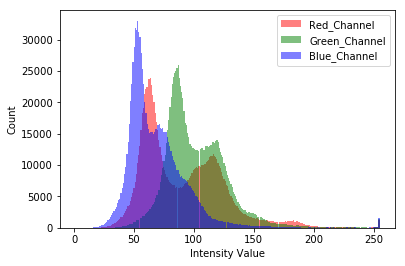

In [59]:
# plot histogram of the channels for one image #entire dataset
from skimage import io
import matplotlib.pyplot as plt
image = x_pre
_ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

# Compute mean & stddev for each tile

In [35]:
# compute mean actual values

mean_std_tile = {}

xBD_all = DisasterDataset_img(data_dir, all_images_ls, transform=True)
print('xBD_disaster_dataset length: {}'.format(len(xBD_all)))

for batch_idx, data in enumerate(xBD_all):
    
    x_pre = data[0]['pre_image']
    x_post = data[0]['post_image']
    x_pre_filename = data[1]['pre_img_file_name'].replace('xBD', 'xBD_sliced')
    x_post_filename = data[1]['post_img_file_name'].replace('xBD', 'xBD_sliced')
    
    mean_std_tile[x_pre_filename]=[(x_pre[:,:,0].mean(), x_pre[:,:,1].mean(), x_pre[:,:,2].mean()), (x_pre[:,:,0].std(), x_pre[:,:,1].std(), x_pre[:,:,2].std())]
    mean_std_tile[x_post_filename]= [(x_post[:,:,0].mean(), x_post[:,:,1].mean(), x_post[:,:,2].mean()), (x_post[:,:,0].std(), x_post[:,:,1].std(), x_post[:,:,2].std())]

with open('./nlrc.building-damage-assessment/constants/splits/all_disaster_mean_stddev_tiles.json', 'w') as f:
    json.dump(mean_std_tile, f, indent=4)

xBD_disaster_dataset length: 11034


In [36]:
# compute mean [0,1]

mean_std_tile = {}
eps = np.finfo(float).eps
xBD_all = DisasterDataset_img(data_dir, all_images_ls, transform=True)
print('xBD_disaster_dataset length: {}'.format(len(xBD_all)))

for batch_idx, data in enumerate(xBD_all):
    
    x_pre = data[0]['pre_image']/255.0
    x_post = data[0]['post_image']/255.0
    x_pre_filename = data[1]['pre_img_file_name'].replace('xBD', 'xBD_sliced')
    x_post_filename = data[1]['post_img_file_name'].replace('xBD', 'xBD_sliced')
    
    mean_std_tile[x_pre_filename]=[(x_pre[:,:,0].mean(), x_pre[:,:,1].mean(), x_pre[:,:,2].mean()), (max(eps, x_pre[:,:,0].std()), max(eps, x_pre[:,:,1].std()), max(eps, x_pre[:,:,2].std()))]
    mean_std_tile[x_post_filename]= [(x_post[:,:,0].mean(), x_post[:,:,1].mean(), x_post[:,:,2].mean()), (x_post[:,:,0].std(), x_post[:,:,1].std(), x_post[:,:,2].std())]

with open('./nlrc.building-damage-assessment/constants/splits/all_disaster_mean_stddev_tiles_0_1.json', 'w') as f:
    json.dump(mean_std_tile, f, indent=4)

xBD_disaster_dataset length: 11034


In [108]:
eps = np.finfo(float).eps
0/eps

0.0

In [100]:
# test a few things
from torchvision import transforms

mean_std_tile = {}

xBD_all = DisasterDataset_img(data_dir, all_images_ls, transform=True)
print('xBD_disaster_dataset length: {}'.format(len(xBD_all)))

for batch_idx, data in enumerate(xBD_all):
    
    x_pre = data[0]['pre_image']
    x_post = data[0]['post_image']
    x_pre_filename = data[1]['pre_img_file_name'].replace('xBD', 'xBD_sliced')
    x_post_filename = data[1]['post_img_file_name'].replace('xBD', 'xBD_sliced')
    
    mean_std_tile[x_pre_filename]=[(x_pre[:,:,0].mean(), x_pre[:,:,1].mean(), x_pre[:,:,2].mean()), (x_pre[:,:,0].std(), x_pre[:,:,1].std(), x_pre[:,:,2].std())]
    mean_std_tile[x_post_filename]= [(x_post[:,:,0].mean(), x_post[:,:,1].mean(), x_post[:,:,2].mean()), (x_post[:,:,0].std(), x_post[:,:,1].std(), x_post[:,:,2].std())]
    
    mean_pre = mean_std_tile[x_pre_filename][0]
    stddev_pre = mean_std_tile[x_pre_filename][1]
    mean_pre
    stddev_pre
    norm_pre = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_pre, std=stddev_pre),
    ])
    make_img_pre = transforms.Compose([
                transforms.ToTensor(),
                transforms.ToPILImage()])
    x_pre
    pre_img = norm_pre(x_pre)
    pre_img
    break

xBD_disaster_dataset length: 1674


(92.90903091430664, 103.32747745513916, 72.64891052246094)

(39.426787318121015, 33.477596964451315, 35.165765158137496)

array([[[114, 109,  74],
        [111, 106,  72],
        [108, 105,  70],
        ...,
        [125, 121,  99],
        [125, 122,  99],
        [127, 124, 101]],

       [[118, 111,  75],
        [120, 113,  77],
        [114, 109,  74],
        ...,
        [123, 120,  97],
        [127, 124, 101],
        [128, 125, 102]],

       [[125, 116,  79],
        [118, 111,  76],
        [119, 113,  77],
        ...,
        [121, 118,  95],
        [127, 124, 100],
        [127, 124, 100]],

       ...,

       [[ 28,  43,  25],
        [ 37,  54,  32],
        [ 40,  58,  35],
        ...,
        [109, 122,  79],
        [100, 114,  72],
        [104, 118,  74]],

       [[ 29,  43,  25],
        [ 39,  57,  34],
        [ 42,  61,  36],
        ...,
        [112, 126,  80],
        [104, 119,  74],
        [ 98, 113,  69]],

       [[ 36,  53,  31],
        [ 36,  52,  30],
        [ 37,  53,  31],
        ...,
        [112, 126,  80],
        [104, 119,  74],
        [ 98, 113,  69]]

tensor([[[-2.3452, -2.3455, -2.3458,  ..., -2.3441, -2.3441, -2.3439],
         [-2.3448, -2.3446, -2.3452,  ..., -2.3443, -2.3439, -2.3438],
         [-2.3441, -2.3448, -2.3447,  ..., -2.3445, -2.3439, -2.3439],
         ...,
         [-2.3537, -2.3528, -2.3525,  ..., -2.3457, -2.3465, -2.3462],
         [-2.3536, -2.3526, -2.3523,  ..., -2.3454, -2.3462, -2.3467],
         [-2.3529, -2.3529, -2.3528,  ..., -2.3454, -2.3462, -2.3467]],

        [[-3.0737, -3.0740, -3.0742,  ..., -3.0723, -3.0722, -3.0719],
         [-3.0735, -3.0732, -3.0737,  ..., -3.0724, -3.0719, -3.0718],
         [-3.0729, -3.0735, -3.0732,  ..., -3.0726, -3.0719, -3.0719],
         ...,
         [-3.0814, -3.0801, -3.0797,  ..., -3.0722, -3.0731, -3.0726],
         [-3.0814, -3.0798, -3.0793,  ..., -3.0717, -3.0725, -3.0732],
         [-3.0803, -3.0804, -3.0803,  ..., -3.0717, -3.0725, -3.0732]],

        [[-2.0576, -2.0579, -2.0581,  ..., -2.0549, -2.0549, -2.0546],
         [-2.0575, -2.0573, -2.0576,  ..., -2

In [103]:
max(0,10)

10